## LQR layering

[array([[10.91435614,  0.9361386 ],
       [ 0.9361386 ,  2.68069298]]), array([[10.91435614,  0.9361386 ],
       [ 0.9361386 ,  2.68069298]]), array([[10.91435614,  0.9361386 ],
       [ 0.9361386 ,  2.68069298]]), array([[10.91435614,  0.9361386 ],
       [ 0.9361386 ,  2.68069297]]), array([[10.91435614,  0.93613864],
       [ 0.93613864,  2.68069269]]), array([[10.91435606,  0.93613924],
       [ 0.93613924,  2.68068809]]), array([[10.91435494,  0.93614841],
       [ 0.93614841,  2.68061321]]), array([[10.91434226,  0.93627149],
       [ 0.93627149,  2.67940524]]), array([[10.91428571,  0.93714286],
       [ 0.93714286,  2.66057143]]), array([[10.90909091,  0.90909091],
       [ 0.90909091,  2.40909091]]), array([[10,  0],
       [ 0,  1]])]
Riccati cost 1590.3493167923618
[Equality(Expression(AFFINE, UNKNOWN, (2,)), Constant(CONSTANT, NONNEGATIVE, (2,)))]

The optimal value is 1590.9493848874904
A solution x is
[[10.          1.43554834  0.18875065 -0.03723119 -0.0852739  -0.0963

ValueError: setting an array element with a sequence.

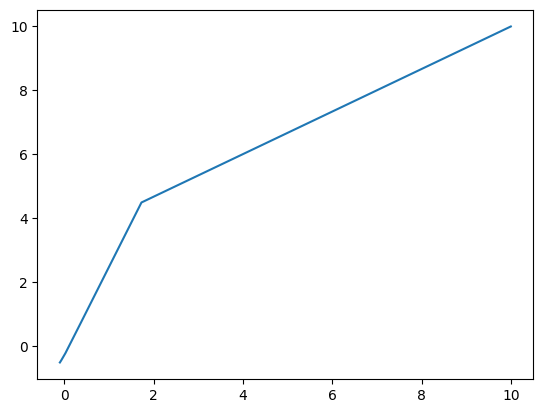

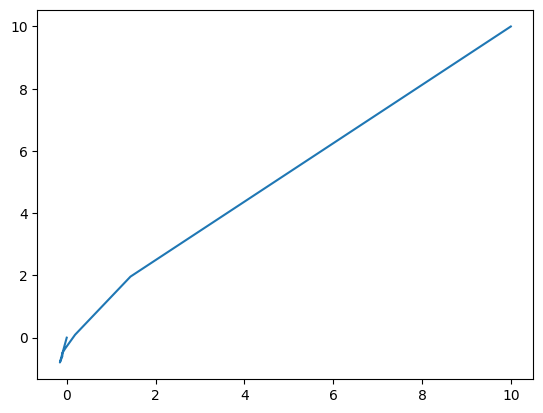

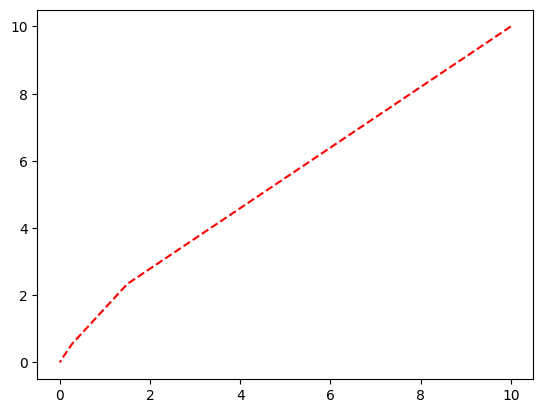

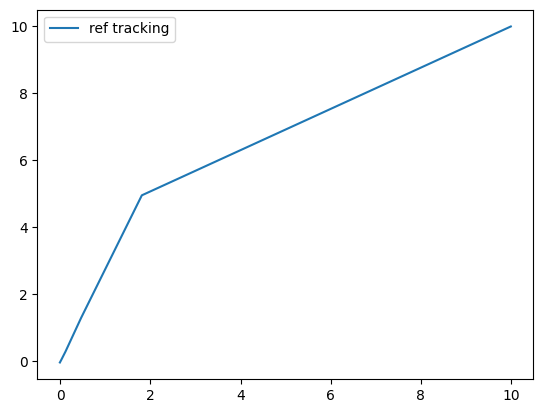

In [132]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag


def V(z, P, p, c):
    return z.T @ P @ z + 2 * p.T @ z + c


def riccati_recursion(A, B, Q, q, R, N):
    
    P = [None] * (N+1)
    p = [None] * (N+1)
    K = [None] * N
    M = [None] * N
    c = [None] * (N+1)
    v = [None] * N
   
    P[N] = Q
    p[N] = q
    c[N] = 0
    
    Mu = []
    
    for t in range(N-1, -1, -1):
 
        K[t] = np.linalg.inv(B.T @ P[t+1] @ B + R) @ B.T @ P[t+1] @ A 
        v[t] = np.linalg.inv(B.T @ P[t+1] @ B + R) @ B.T @ p[t+1]
        M[t] = K[t].T @ R @ np.linalg.inv(B.T @ P[t+1] @ B + R) @ B.T + (A - B @ K[t]).T @ (np.eye(A.shape[0]) - P[t+1] @ B @ np.linalg.inv(B.T @ P[t+1] @ B + R) @ B.T)
        P[t] = Q + A.T @ P[t+1] @ A - A.T @ P[t+1] @ B @ K[t]
        p[t] = q + K[t].T @ R @ v[t] + (A- B @ K[t]).T @ (p[t+1] - P[t+1] @ B @ v[t])
        c[t] = -p[t+1].T @ B @ np.linalg.inv(B.T @ P[t+1] @ B + R) @ B.T @ p[t+1] + c[t+1]
        
    return P, p, c, K, M, v


def main():
    
    N = 10
    
    n = 2
    m = 2
    
    A = np.array([[1, 1], [0, 1]])
    B = np.eye(m)
    
    Q = np.array([[10, 0], [0, 1]])
    R = np.eye(m)
    
    q = np.ones(2)
    
    x0 = np.array([10, 10])
    
    P, p, c, K, M, v = riccati_recursion(A, B, Q, q, R, N)
    
    print(P)
        
    cost = V(x0, P[0], p[0], c[0])
    
    print("Riccati cost", cost)
    
    ## Evolution of trajectory from layering
    u_lqr = np.zeros([m, N])
    x_lqr = np.zeros([n, N+1])
    
    x_lqr[:, 0] = x0
    
    for i in range(N):
        u_lqr[:, i] = -K[N-i-1] @ x_lqr[:, i] - v[N-i-1]
        x_lqr[:, i+1] = A @ x_lqr[:, i] + B @ u_lqr[:, i]
        
    plt.figure()
    plt.plot(x_lqr[0, :], x_lqr[1, :])
    
    x = cp.Variable(shape=(n, N+1))
    u = cp.Variable(shape=(m, N))
    
    constr = []

    obj = cp.Minimize(cp.sum([cp.quad_form(x[:, i], Q) + cp.quad_form(u[:, i], R) + 2 * q @ x[:, i] for i in range(N)]))
    constr.append(x[:, 0] == x0)

    print(constr)

    for i in range(N-1):
        constr.append(x[:, i+1] == A @ x[:, i] + B @ u[:, i])


    prob = cp.Problem(obj, constr)

    prob.solve()

    # Print result.
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    print("A dual solution corresponding to the inequality constraints is")
    print(prob.constraints[0].dual_value)
    
    plt.figure()
    plt.plot(x[0].value, x[1].value)
    
    F = np.hstack([np.eye(n), np.zeros([n, n * (N+1)])])
    mu = 0.1 * np.ones([n, N+1])
    
    #reference_tracking(A, B, Q, R, N, F, np.zeros(x.shape), n, m, mu, x0)
    
    # ADMM
    #not_converged = True
    
    #while not_converged:
    P, p, c, Nu, Psi, x, u = reference_tracking(A, B, Q, R, N, F, np.zeros(x.shape), n, m, mu, x0)
    r = planning(P, Psi, x0, Nu, n, N, Q)
        #mu --> updates
    
        
if __name__ == '__main__':
    main()

## Reference Trajectory Tracking Problem

In [131]:
def planning(P0, Psi, x0, Nu, n, N, Q):
    
    r = cp.Variable(shape=(n, N+1))
    util_cost = [cp.quad_form(r[:, i], Q) for i in range(N+1)]
    z0 = np.append(x0, r)
    
    P_bar = P0 + Nu @ np.linalg.inv(Psi) @ Nu.T
    print("P_bar", P_bar.shape)
    track_cost = cp.quad_form(z0, P_bar)
    
    obj = cp.Minimize(cp.sum[util_cost, track_cost])
    
    constr = []
    constr.append(r[:, 0] == x0)
    
    prob = cp.Problem(obj, constr)
    
    # Print result.
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    print("A dual solution corresponding to the inequality constraints is")
    print(prob.constraints[0].dual_value)
    
    plt.figure()
    plt.plot(r[0].value, r[1].value)
    
    return r.value
    

def reference_tracking(A, B, Q, R, N, F, r, n, m, mu, x0):
    
    # Using cvxpy 

    x = cp.Variable(shape=(n, N+1))
    #z = cp.Variable(shape=(n * (N+2), N+1))
    u = cp.Variable(shape=(m, N))
    
    #z = np.zeros([n * (N+2), N+1])
    
    
    constr = []

    stage_cost = [cp.quad_form(x[:, i] - r[:, i], Q) + cp.quad_form(u[:, i], R) for i in range(N)]
    term_cost = cp.quad_form(x[:, N] - r[:, N], Q)

    stage_cost.append(term_cost)
    obj = cp.Minimize(cp.sum(stage_cost))
    
    constr.append(x[:, 0] == x0)


    for i in range(N-1):
        constr.append(x[:, i+1] == A @ x[:, i] + B @ u[:, i])


    prob = cp.Problem(obj, constr)

    prob.solve()

    # Print result.
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    print("A dual solution corresponding to the inequality constraints is")
    print(prob.constraints[0].dual_value)
    
    plt.figure()
    plt.plot(x[0].value, x[1].value, 'r--')
    plt.plot(r[0], r[1])
    
    # Using Riccati
    
    E1 = np.vstack([np.eye(n), np.zeros([n * N, n])])
    E2 = np.vstack([np.zeros([n, n]), np.eye(n), np.zeros([n *(N-1), n])])
    M = np.eye(n * (N+1), n * (N+1), 1)
    
    Q_bar = np.block([[Q, np.zeros([n, (N+1) * n])], [np.zeros([(N+1) * n, n]), np.zeros([(N+1) * n, (N+1) * n])]])
    A_bar = np.block([[A, E2.T - A @ E1.T], [np.zeros([n*(N+1), n]), M]])
    B_bar = np.vstack([B, np.zeros([n * (N+1), m])])
    
    q = np.zeros([n * (N+2), N+1])
    for i in range(N+1):
        q[:, i] = F.T @ mu[:, 0]
    
    P, p, c, K, M, v = riccati_recursion(A_bar, B_bar, Q_bar, q, R, N)
    
    z0 = np.append(x0, r.ravel(order='F'))
    
    # TODO: Fix dimensions
    
    cost = V(z0, P[0], p[0].T[0], c[0][0, 0])
    print("Reference Riccati cost", cost)
    
    Nu_mat = []
    for i in range(N):
        if i > 0:
            Nu_mat.append(Nu_mat[-1] @ M[i])
        else:
            Nu_mat.append(M[i])

    Nu = np.block([Nu_mat[i] @ F.T for i in range(N)])
    
    Psi_mat = []
    
    for i in range(N):
        Psi_mat.append(F @ Nu_mat[i].T @ B_bar @ np.linalg.inv(R + B_bar.T @ P[i+1] @ B_bar) @ B_bar.T @ Nu_mat[i] @ F.T)

    # TODO: Change this
    Psi = block_diag(Psi_mat[0], Psi_mat[1], Psi_mat[2], Psi_mat[3], Psi_mat[4], Psi_mat[5], Psi_mat[6], Psi_mat[7],
                    Psi_mat[8], Psi_mat[9])
    
    
    ## Evolution of trajectory from layering
    u_lqr = np.zeros([m, N])
    x_lqr = np.zeros([n, N+1])
    z_lqr = np.zeros([n * (N+2), N+1])
    
    x_lqr[:, 0] = x0
    
    for i in range(N+1): 
        z_lqr[:n, i] = x_lqr[:, i] - r[:, i]
        z_lqr[n:(N-i+2)*n, i] = r[:, i:].ravel(order='F')
    
    
    for i in range(N):
        u_lqr[:, i] = -K[N-i-1] @ z_lqr[:, i] - v[N-i-1][:, 0]
        z_lqr[:, i+1] = A_bar @ z_lqr[:, i] + B_bar @ u_lqr[:, i]
        
    plt.figure()
    plt.plot(z_lqr[0, :], z_lqr[1, :], label="ref tracking")
    plt.legend()
    
    return P, p, c, Nu, Psi, z_lqr, u_lqr


In [38]:
Q_bar = np.block([[Q, np.zeros([n, (N+1) * n])], [np.zeros([(N+1) * n, n]), np.zeros([(N+1) * n, (N+1) * n])]])
    
F = np.vstack([np.eye(n), np.zeros([n * (N+1), n])])
print(Q_bar)
e = np.array([2, 3])

z = np.ones([n * (N+2)])

z[:n] = e

print(F.T @ z)
print(e)

[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[2. 3.]
[2 3]


In [ ]:
import cvxpy as cp
import numpy as np

def sample_int_wp(initial_loc, goal, num_waypoints):
    # Create a 2D grid of possible waypoints
    x_vals = np.linspace(initial_loc[0], goal[0], num_waypoints)
    y_vals = np.linspace(initial_loc[1], goal[1], num_waypoints)
    xx, yy = np.meshgrid(x_vals, y_vals)
    waypoints = np.stack((xx.ravel(), yy.ravel()), axis=1)

    # Randomly select num_waypoints from the grid
    selected_indices = np.random.choice(waypoints.shape[0], num_waypoints, replace=False)
    selected_waypoints = waypoints[selected_indices]

    return selected_waypoints

def sample_rand_wp(start, goal, waypoints):
    # Generate unequally spaced waypoints between start and goal with same number of waypoints in each dimension
    num_dimensions = len(start)
    waypoints = np.zeros((num_waypoints, num_dimensions))
    for i in range(num_dimensions):
        x_vals = np.random.uniform(start[i], goal[i], size=num_waypoints)
        waypoints[:, i] = np.sort(x_vals)
    return waypoints



# Optimal control problem

n = 2
p = 2

x0 = np.array([10, 10])

A = np.array([[1, 0], [0, 1]])

B = np.eye(2)

N = 50

x = cp.Variable(shape=(n, N))
u = cp.Variable(shape=(p, N))

Q = np.array([[10, 0], [0, 1]])
R = np.eye(2)

constr = []

num_wp = 3

# Generate waypoints
#w = sample_int_wp([10, 10], [0, 0], 3).T
#print("Waypoints", w)

w = np.array([[5, 3, 1], [5.5, 2.8, 1]])

wp_times = np.round(np.linspace(1, N, num_wp+2)[1:-1]).astype(int)

# Instead of using quad_form for x, use distance to waypoints 
obj1 = cp.Minimize(cp.sum([cp.quad_form(x[:, i] - w[:, j], np.eye(n)) for i, j in zip(np.round(np.linspace(1, N, num_wp+2)[1:-1]).astype(int), range(num_wp))]))

obj2 = cp.Minimize(cp.sum([cp.quad_form(x[:, i], Q) + cp.quad_form(u[:, i], R) for i in range(N)]))
constr.append(x[:, 0] == x0)

print(constr)

for i in range(N-1):
    constr.append(x[:, i+1] == A @ x[:, i] + B @ u[:, i])


prob = cp.Problem(obj1+obj2, constr)

prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)

## No waypoints

In [1]:
import cvxpy as cp
import numpy as np

# Optimal control problem

n = 2
p = 2

x0 = np.array([10, 10])

A = np.array([[1, 0], [0, 1]])

B = np.eye(2)

N = 6

x = cp.Variable(shape=(n, N))
u = cp.Variable(shape=(p, N))

Q = np.array([[10, 0], [0, 1]])
R = np.eye(2)

constr = []

obj = cp.Minimize(cp.sum([cp.quad_form(x[:, i], Q) + cp.quad_form(u[:, i], R) for i in range(N)]))
constr.append(x[:, 0] == x0)

print(constr)

for i in range(N-1):
    constr.append(x[:, i+1] == A @ x[:, i] + B @ u[:, i])


prob = cp.Problem(obj, constr)

prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)

[Equality(Expression(AFFINE, UNKNOWN, (2,)), Constant(CONSTANT, NONNEGATIVE, (2,)))]

The optimal value is 1253.4057311172305
A solution x is
[[1.00000000e+01 8.39202169e-01 7.04260301e-02 5.91019215e-03
  4.96275677e-04 4.51159706e-05]
 [1.00000000e+01 3.82022472e+00 1.46067416e+00 5.61797753e-01
  2.24719101e-01 1.12359551e-01]]
A dual solution corresponding to the inequality constraints is
[-218.32159566  -32.35955056]


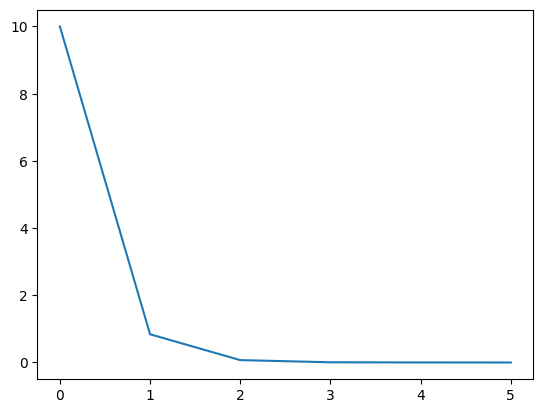

In [2]:
import matplotlib.pyplot as plt

#plt.plot(x.value[0])
#plt.plot(x.value[1])
plt.plot(x.value[0])

init_ref = x.value

In [ ]:
%matplotlib notebook

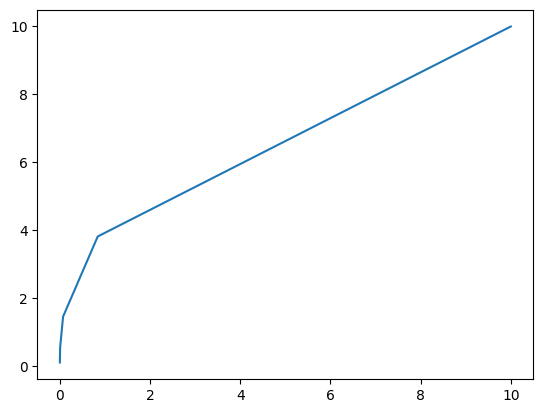

In [3]:
plt.plot(x.value[0], x.value[1])

In [ ]:
# Tradeoff curve between tracking vs waypoint satisfiability

## ADMM

In [ ]:
import cvxpy as cp
import numpy as np
    

N = 50

n = 2

p = 2

x0 = np.array([10, 10])

A = np.eye(n)

B = np.eye(p)

E1 = np.vstack([np.eye(n), np.zeros([n * N, n])])
print(E1.shape)
E2 = np.vstack([np.zeros([n, n]), np.eye(n), np.zeros([n *(N-1), n])])
print(E2.shape)

M = np.eye(n * (N+1), n * (N+1), 1)
print(M.shape)


A_tilde = np.block([[A, E2.T - A @ E1.T], [np.zeros([n*(N+1), n]), M]])
B_tilde = np.vstack([B, np.zeros([n * (N+1), p])])


z = cp.Variable(shape=(n, N+2))


#x = cp.Variable(shape=(n, N))
#u = cp.Variable(shape=(p, N))
v = np.zeros([n, N])


def solve_dare(A, B, E1, R, rho):
    P = []
    Q = []
    c = -(rho * rho/4) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ E1.T @ A
    print("c", c.shape)
    P_next = (rho/2) * (A+np.eye(A.shape[0])) @ E1 @ v[:, N-2] - (rho * rho/4) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ v[:, N-1]
    Q_next = (rho/2) * (E1 @ E1.T + A.T @ E1 @ E1.T @ A) + c
    

    t = N-2
    while True:
        Q.append(Q_next)
        P.append(P_next)
        S = R + B.T @ Q_next @ B
        print("S", S.shape)
        K = A.T @ Q_next @ B @ np.linalg.inv(S)
        print("P", P_next.shape)
        print("A", A.shape)
        print("K", K.shape)
        print("B", B.shape)
        P_next = E1 @ v[:, t].T + A.T @ P_next @ K @ B.T @ P_next
        Q_next = (rho/2) * (E1 @ E1.T + A.T @ Q_next @ A - K @ B.T @ Q_next @ A)
        t -= 1

        print(P_next)
        #if np.allclose(P[-1], P_next):
        if np.linalg.norm(P[-1]-P_next) < 1e-2:
            break

    return Q, P, c

R = np.eye(p)
rho = 0.1

E1_tilde = np.vstack([E1, np.zeros([2, 2])])

Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho)

print(Q_cost)
print(P_cost)
print(c_cost)


# Updates to dual variables





## Run until convergence

J0 <function J_0 at 0x7f43135c43a0>
(12,)
Computed z [ 1.77635684e-15  1.77635684e-15  4.40735667e-18  4.61568019e-18
 -4.18753166e-18 -4.60517753e-18 -2.19293478e-19 -1.04431893e-20
 -5.12029184e-22 -5.94720087e-23 -1.94952368e-23 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
Qcost 6
Pcost 6
(2,)
u0 [0.51626354 0.51626354]
(2,)
u0 [0.47375661 0.47375661]
(2,)
u0 [0.44941048 0.44941048]
(2,)
u0 [0.42696509 0.42696509]
(2,)
u0 [0.40566862 0.40566862]


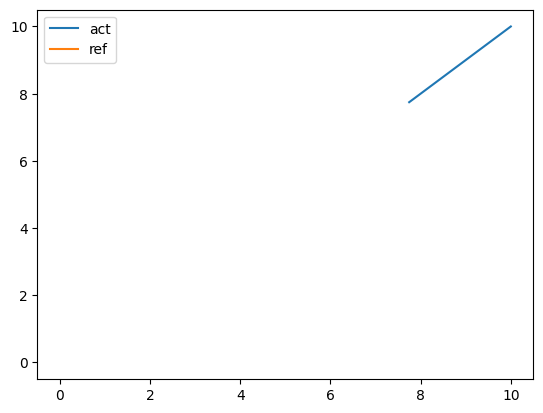

v shape (2, 6)
30.67783779258444
Computed z [-1.00000000e+01 -1.00000000e+01 -2.48112123e-02 -2.59839695e-02
  2.35737075e-02  2.59248448e-02  1.23451253e-03  5.87899294e-05
  2.88246805e-06  3.34797645e-07  1.09748427e-07 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
Qcost 6
Pcost 6
(2,)
u0 [5.05707126 5.05726951]
(2,)
u0 [8.63109949 8.6312637 ]
(2,)
u0 [12.06371718 12.06387472]
(2,)
u0 [15.35796616 15.35817421]
(2,)
u0 [18.53891419 18.53917034]


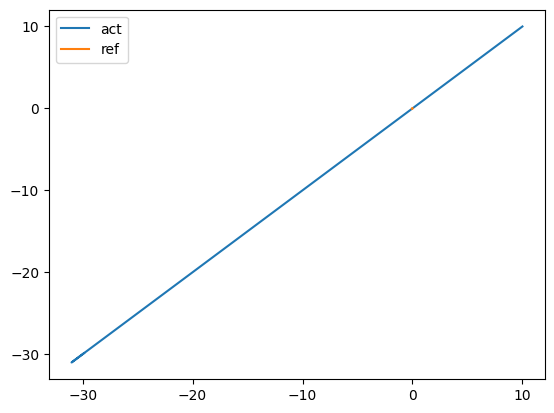

v shape (2, 6)
66.90988783928711
Computed z [-10.02481121 -10.02598397 -16.12916645 -28.25050155  -4.41700774
  15.38257538  15.32660786  12.23261105   5.28486223   0.63531513
  -0.0652959   -0.          -0.          -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [-12.25524688 -13.12713961]
(2,)
u0 [-14.58828011 -12.76246504]
(2,)
u0 [-8.46027293 -6.22047757]
(2,)
u0 [0.74484189 3.01015308]
(2,)
u0 [11.25358498 14.00611821]


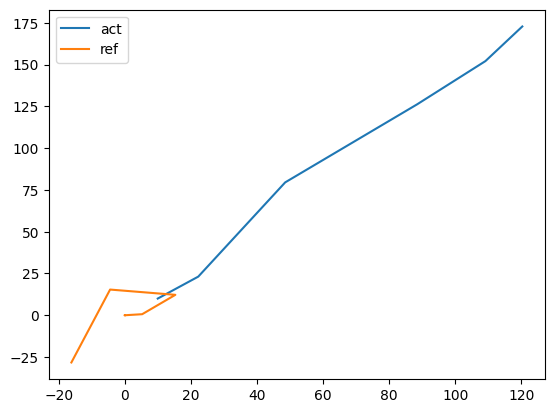

v shape (2, 6)
328.111442221127
Computed z [-26.12916645 -38.25050155   4.71998501  16.81474309  22.94466329
  11.40128973 -12.96182321 -26.42826801 -14.88636867  -1.78776481
   0.18354358  -0.          -0.          -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [39.00044528 72.26118942]
(2,)
u0 [ 69.12159455 123.02199493]
(2,)
u0 [ 89.00417518 147.59126765]
(2,)
u0 [109.10322536 148.84817044]
(2,)
u0 [119.41961334 143.90724049]


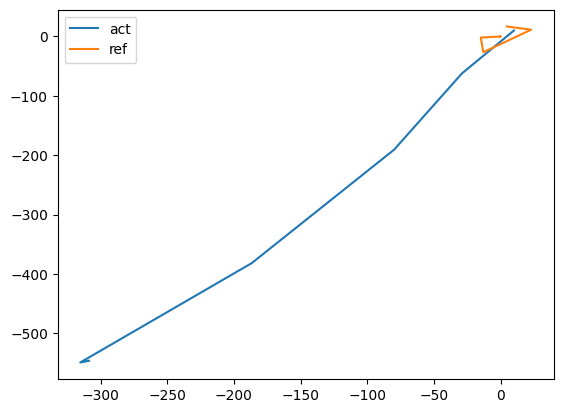

v shape (2, 6)
1004.3824782535183
Computed z [  -5.28001499    6.81474309 -119.34164404 -260.7102549  -108.0395763
   96.66551503  149.55223051  153.59195371   78.93463373   10.45278616
   -1.1056439    -0.           -0.           -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [-125.21379357 -240.09483986]
(2,)
u0 [-185.80316787 -324.48167865]
(2,)
u0 [-171.03638818 -313.53632426]
(2,)
u0 [-130.00929876 -276.27055817]
(2,)
u0 [ -84.37096074 -207.33973014]


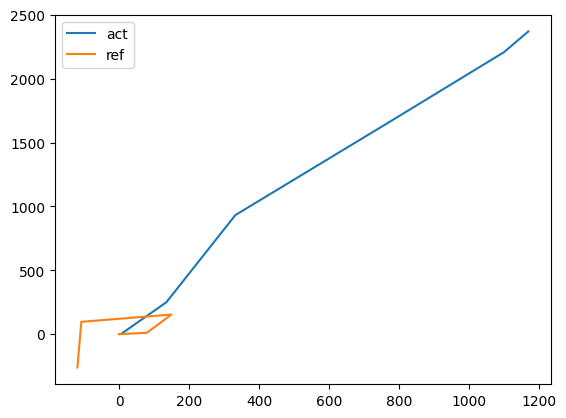

v shape (2, 6)
4115.1252825808315
Computed z [-129.34164404 -270.7102549   178.60645623  567.08687092  385.6394038
  -91.9559878  -310.76974438 -440.73423233 -256.82471599  -34.39665079
    3.34860035   -0.           -0.           -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ 386.35235928 1006.50237462]
(2,)
u0 [ 647.55504006 1550.61931426]
(2,)
u0 [ 742.48351616 1715.00620259]
(2,)
u0 [ 829.16555376 1605.08608987]
(2,)
u0 [ 817.65039373 1391.25682795]


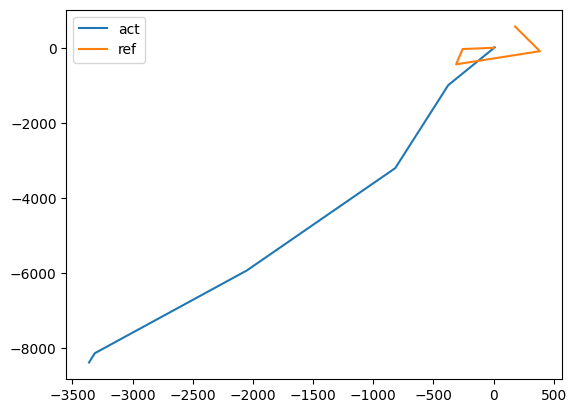

v shape (2, 6)
14374.972161148642
Computed z [  168.60645623   557.08687092  -954.0853069  -2713.55456996
 -1601.88336896   707.3037034   1501.09643297  1858.97470645
  1069.87494046   147.27616011   -15.00269757    -0.
    -0.            -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [-1212.62008396 -3595.67062877]
(2,)
u0 [-1931.55404232 -5260.17900124]
(2,)
u0 [-1973.71952833 -5540.10388376]
(2,)
u0 [-1866.75693846 -5152.82282659]
(2,)
u0 [-1606.6825579  -4323.04139758]


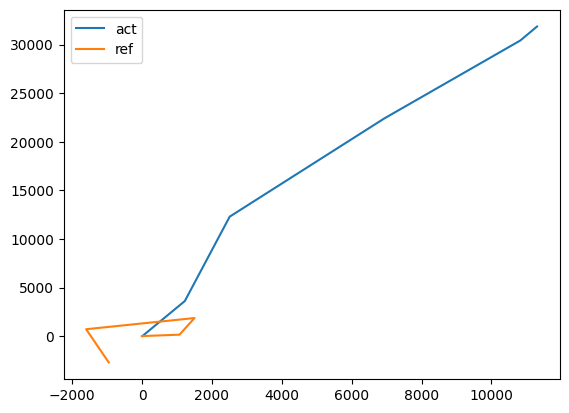

v shape (2, 6)
53423.375299013554
Computed z [ -964.0853069  -2723.55456996  2319.978579    8544.09768004
  5914.33330279 -1771.17734695 -4508.19186569 -6244.8117087
 -3777.86927116  -528.10862439    51.74925506    -0.
    -0.            -0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ 3691.02213714 13578.24075792]
(2,)
u0 [ 6252.98102145 20365.35004818]
(2,)
u0 [ 6807.54201615 21974.58895574]
(2,)
u0 [ 7241.00165516 20455.76964515]
(2,)
u0 [ 6808.13526478 17379.01028756]


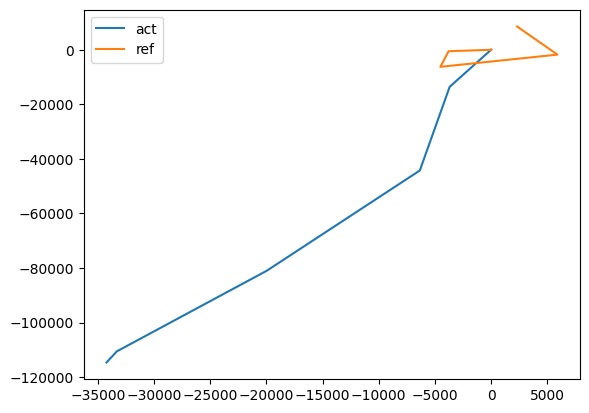

v shape (2, 6)
190572.40205105898
Computed z [  2309.978579     8534.09768002  -8568.7842058  -32090.08068593
 -22262.74519323   6991.45851159  16850.98692333  23088.86117682
  14179.64452861   2009.76099752   -199.10205291      0.
      0.              0.        ]
Qcost 6
Pcost 6
(2,)
u0 [-11248.95478312 -48834.54132483]
(2,)
u0 [-18907.74554411 -72608.99900265]
(2,)
u0 [-19833.13830639 -77715.67616789]
(2,)
u0 [-20167.32729328 -72570.94254855]
(2,)
u0 [-18175.5847406  -61502.69024408]


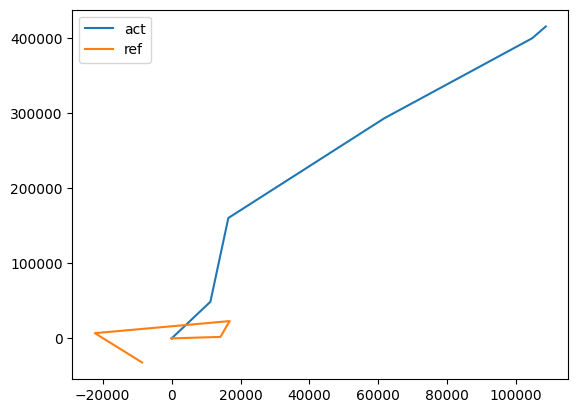

v shape (2, 6)
684703.1800981764
Computed z [ -8578.78420576 -32100.08068579  24499.57987424 109676.19721501
  81501.29903599 -21944.34259565 -56055.59900467 -80470.04983506
 -50655.02020216  -7261.8047843     709.7402966       0.
      0.              0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ 33496.07734176 176911.90811015]
(2,)
u0 [ 58776.02202738 264299.30791101]
(2,)
u0 [ 62657.88423927 284180.05717401]
(2,)
u0 [ 66493.92856595 265222.04415446]
(2,)
u0 [ 61535.42036584 225080.53808915]


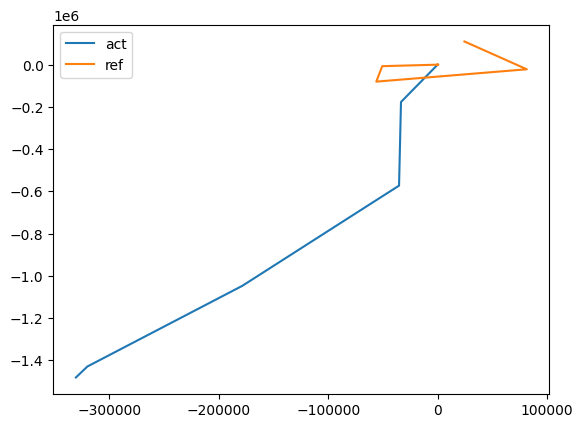

v shape (2, 6)
2425980.0947135896
Computed z [  24489.57987405  109666.19721416  -79616.95561907 -387643.21592802
 -295929.79438538   76051.01965997  195534.54741079  285165.75866151
  182594.45777905   26426.43760654   -2582.25518539       0.
       0.               0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ -98281.55280712 -629264.26331997]
(2,)
u0 [-175941.39560439 -939302.17174877]
(2,)
u0 [ -185000.98519011 -1009272.92378935]
(2,)
u0 [-196007.23464509 -943644.58626084]
(2,)
u0 [-179046.01615158 -801154.8057956 ]


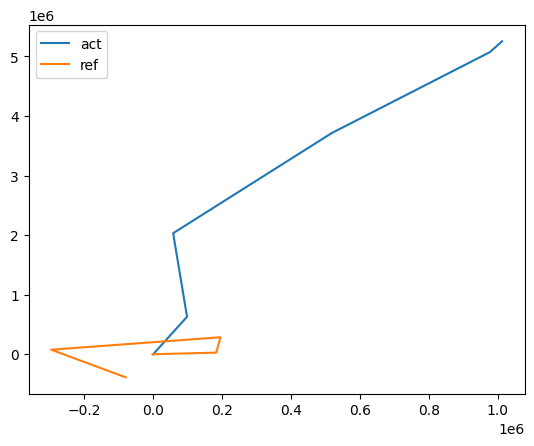

v shape (2, 6)
8565774.809743276
Computed z [ -79626.95561795 -387653.21592255  236778.29694129 1336851.12904532
 1062492.71665711 -249947.90834596 -662028.60162367 -992554.69207572
 -646409.45677773  -94348.52862364    9167.044803         0.
       0.               0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ 280802.49195439 2230363.10412659]
(2,)
u0 [ 526468.5017461  3333338.28065099]
(2,)
u0 [ 554181.15474936 3585936.34606916]
(2,)
u0 [ 602691.48827824 3353482.56183788]
(2,)
u0 [ 555736.20242643 2848223.28954391]


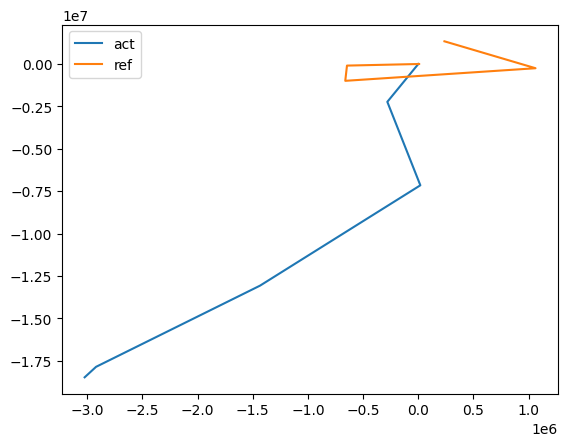

v shape (2, 6)
30018193.54815815
Computed z [  236768.29693539  1336841.12901163  -725316.1022299  -4624698.60920382
 -3781463.69646985   836521.38176884  2257341.68125185  3452656.42183542
  2281960.38050625   335520.80559955   -32522.26305834        0.
        0.                0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ -776132.39536695 -7830526.88738741]
(2,)
u0 [ -1529486.13049122 -11706996.20635748]
(2,)
u0 [ -1596045.09015028 -12599225.10556926]
(2,)
u0 [ -1767268.40057104 -11793887.89920804]
(2,)
u0 [ -1624562.08741687 -10021645.70023807]


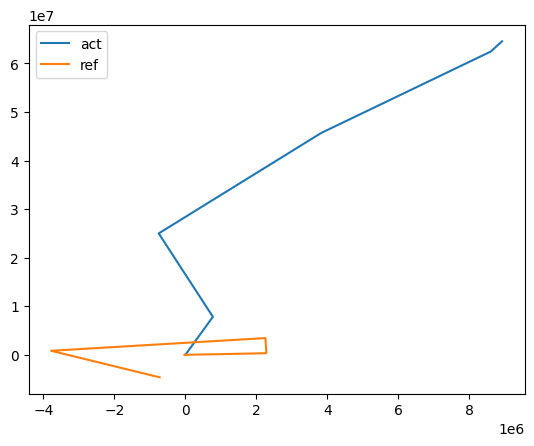

v shape (2, 6)
104669696.42726246
Computed z [  -725326.10223022  -4624708.6092032    2134419.66391524
  15853377.39925435  13354351.34789329  -2759383.73925684
  -7620942.84103771 -11912524.22086218  -7981963.65967988
  -1181469.43913536    114135.48890906         0.
         0.                 0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ 2040672.81424495 27344946.55204063]
(2,)
u0 [ 4352910.11222923 40905813.39164485]
(2,)
u0 [ 4514537.6432073 44049591.6066027]
(2,)
u0 [ 5162240.7879276  41252839.76491635]
(2,)
u0 [ 4767671.1208277  35064819.97477562]


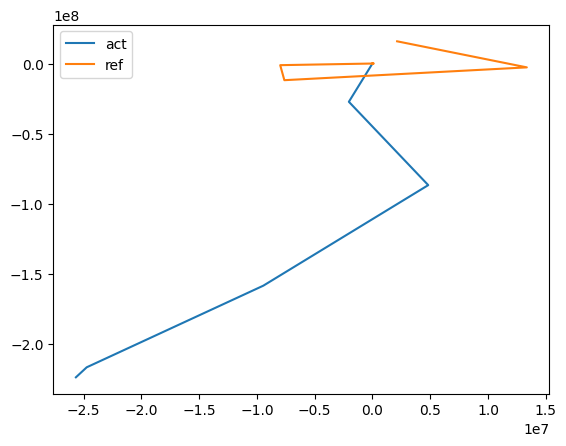

v shape (2, 6)
362934559.132944
Computed z [  2134409.66391549  15853367.39925391  -6234165.5656883
 -54179040.39557161 -46829140.38563909   9103204.39088286
  25681041.73308302  40938950.58385885  27780920.54630186
   4136885.42083012   -398656.32805851         0.
         0.                 0.        ]
Qcost 6
Pcost 6
(2,)
u0 [ -4944149.01736868 -94869746.72343102]
(2,)
u0 [-1.19002155e+07 -1.41981520e+08]
(2,)
u0 [-1.21928950e+07 -1.52967037e+08]
(2,)
u0 [-1.45240228e+07 -1.43346987e+08]
(2,)
u0 [-1.34293446e+07 -1.21889153e+08]


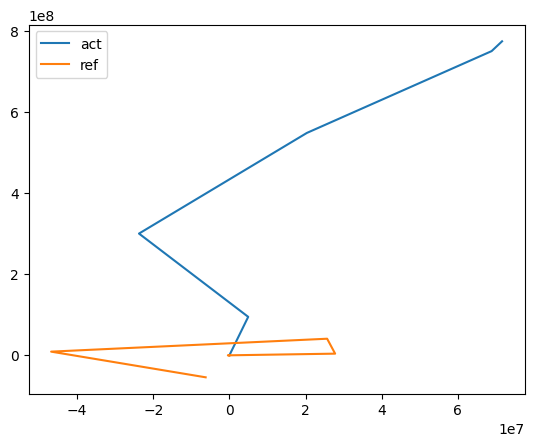

v shape (2, 6)
1252339645.0645556
Computed z [-6.23417557e+06 -5.41790504e+07  1.75858799e+07  1.84145339e+08
  1.63186099e+08 -2.98390794e+07 -8.60716759e+07 -1.39918325e+08
 -9.60832941e+07 -1.43879347e+07  1.38299114e+06  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Qcost 6
Pcost 6
(2,)
u0 [1.01962613e+07 3.27419288e+08]
(2,)
u0 [3.08586529e+07 4.90229828e+08]
(2,)
u0 [3.10712892e+07 5.28402016e+08]
(2,)
u0 [3.95051712e+07 4.95409291e+08]
(2,)
u0 [3.67056844e+07 4.21373014e+08]


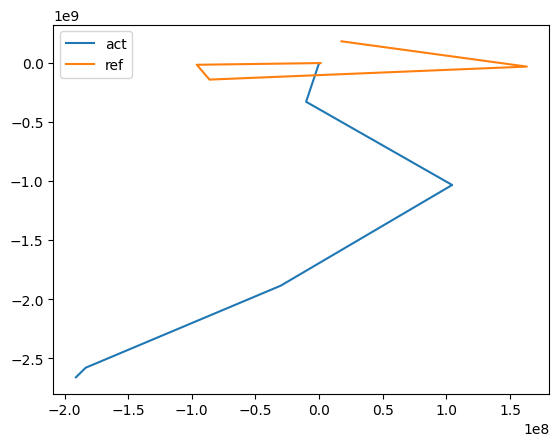

v shape (2, 6)
4300648641.465691
Computed z [ 1.75858699e+07  1.84145329e+08 -4.79377583e+07 -6.23298379e+08
 -5.65334441e+08  9.74284459e+07  2.87394201e+08  4.76099508e+08
  3.30651328e+08  4.97704253e+07 -4.77332983e+06  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Qcost 6
Pcost 6
(2,)
u0 [-1.28052344e+07 -1.12402874e+09]
(2,)
u0 [-7.27924288e+07 -1.68365510e+09]
(2,)
u0 [-7.08483816e+07 -1.81554637e+09]
(2,)
u0 [-1.00873124e+08 -1.70305606e+09]
(2,)
u0 [-9.42628079e+07 -1.44897946e+09]


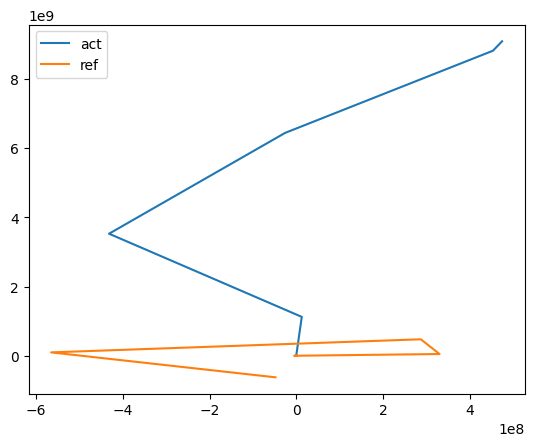

v shape (2, 6)
14702512530.08056


SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [26]:
# Optimization for reference r - without scaling dual variables
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

from scipy.linalg import solve_discrete_are


def generate_polynomial_coeffs(start, end, T, order):
    """
    Generates a polynomial trajectory from start to end over time T
    start: start state
    end: end state
    T: total time
    order: order of the polynomial
    """
    # Define the time vector
    t = np.linspace(0, 1, T)

    # Solve for the polynomial coefficients
    coeffs = np.polyfit(t, t * (end - start) + start, order)

    # Evaluate the polynomial at the desired time steps
    polynomial = np.polyval(coeffs[::-1], t)
    trajectory = polynomial + start

    return coeffs


def solve_dare(A, B, E1, R, rho, v, N):
    """
    Recursions to compute DARE solution for linear system
    """
    P = []
    Q = []
    c = []
    
    # Quadratic cost factor 
    P_next = rho * (A+np.eye(A.shape[0])) @ E1 @ v[:, N-1] - (rho * rho/2) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ v[:, N]
    Q_next = (rho/2) * (E1 @ E1.T + A.T @ E1 @ E1.T @ A) - (rho * rho/4) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ E1.T @ A
    c_next = -(rho ** 2/4) * v[:, N].T @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ v[:, N]
    
    Q.append(Q_next)
    P.append(P_next)
    c.append(c_next)

    t = N-1
    while t >= 0:
        S = R + B.T @ Q_next @ B

        K = A.T @ Q_next @ B @ np.linalg.inv(S)
        c_next = c[-1] - P_next @ B @ np.linalg.inv(S) @ B.T @ P_next
        P_next = E1 @ v[:, t] + P_next.T @ A - K @ B.T @ P_next
        Q_next = (rho/2) * (E1 @ E1.T + A.T @ Q_next @ A - K @ B.T @ Q_next @ A)
        
        Q.append(Q_next)
        P.append(P_next)
        c.append(c_next)

        t -= 1

    return Q, P, c


N = 5

n = 2

p = 2

x0 = np.array([10, 10])

A = np.eye(n)

B = np.eye(p)

E1 = np.vstack([np.eye(n), np.zeros([n * N, n])])

E2 = np.vstack([np.zeros([n, n]), np.eye(n), np.zeros([n *(N-1), n])])

M = np.eye(n * (N+1), n * (N+1), 1)


A_tilde = np.block([[A, E2.T - A @ E1.T], [np.zeros([n*(N+1), n]), M]])
B_tilde = np.vstack([B, np.zeros([n * (N+1), p])])

v = np.zeros([n, N+1])

Q = np.array([[10, 0], [0, 1]])

R = np.eye(p)

rho = 0.1

E1_tilde = np.vstack([E1, np.zeros([2, 2])])

Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho, v, N)


# Generate polynomial trajectory

r0 = np.zeros([N+1, n])
r0[0, :] = [10, 10]
for i in range(n):
    coeff = generate_polynomial_coeffs(x0[i], 0, N+1, 4)
    r0[:, i] = np.polyval(coeff, np.linspace(0, 1, N+1))

    
#r0 = init_ref.T
#print(r0.shape)
#plt.plot(r0)

# compose z0 by using the initial condition and initial guess of the reference and compute J0(z0)


# Define z as a cvxpy var and enforce constraint for x to be set to cur pos
z = cp.Variable(shape=(n * (N+2)))

def J_0(z, Q, P, c):
    return cp.quad_form(z, Q) + P.T @ z + c 


print("J0", J_0)

x = np.zeros([n, N+1])
x[:, 0] = x0

u = np.zeros([p, N])


not_converged = True
constr = []
constr1 = []

r = r0.ravel()
print(r.shape)
#Q_cost = np.zeros([n * (N+2), n * (N+2)])
#print(cp.quad_form(z, Q_cost))

num = 0
while not_converged:
    
    # Define z as a cvxpy var and enforce constraint for x to be set to cur pos
    z = cp.Variable(shape=(n * (N+2)))
    # Compute ref
    #if num == 0:
        #obj = cp.Minimize(cp.sum([cp.quad_form(z[n*(i+1):n*(i+2)] - r[n*i:n*(i+1)], np.eye(n)) for i in range(N+1)]))
    #    obj = cp.Minimize(cp.sum([cp.quad_form(z[n*(i+1):n*(i+2)], np.eye(n)) for i in range(N+1)]))
    #else:     
    obj = cp.Minimize(cp.sum([cp.quad_form(z[n*(i+1):n*(i+2)], np.eye(n)) for i in range(N+1)]) + J_0(z, Q_cost[-1], P_cost[-1], c_cost[-1]))

    constr.append(z[0:n] == r[:n] - x0)
    constr.append(z[-n:] == np.zeros(n))
    
    prob = cp.Problem(obj, constr)
    prob.solve()
    
    """plt.figure()
    plt.plot(x[1, :])
    plt.plot(z.value[n::2])
    plt.show()"""
    
    print("Computed z", z.value)
    
    
    # Compute x and u
    Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho, v, N)
    print("Qcost", len(Q_cost))
    print("Pcost", len(P_cost))
    r = z.value[n:]
    z_next = np.zeros(z.value.shape)
    
    for t in range(N):
        z_next[:n] = r[:n] - x[:, t]
        z_next[n:n*(N-t+2)] = r[n*t:] 
        #if t > 0:
        #    z_next[n*(N-t+2)::n] = r[-2] * np.ones(t) # TODO: change it to repeating values of r[N]
        #    z_next[n*(N-t+2)+1::n] = r[-1] * np.ones(t)
        u0 = -np.linalg.inv(R + B_tilde.T @ Q_cost[t+1] @ B_tilde) @ (B_tilde.T @ Q_cost[t+1] @ A_tilde @ z_next + (1/2) * B_tilde.T @ P_cost[t+1])
        print(u[:, t].shape)
        print("u0", u0)
        if t == N-1:
            u[:, t] = -rho/2 * np.linalg.inv(R + (rho/2) * B_tilde.T @ E1_tilde @ E1_tilde.T @ B_tilde) @ (B_tilde.T @ E1_tilde @ v[:, t+1] + B_tilde.T @ E1_tilde @ E1_tilde.T @ A_tilde @ z_next)
        else:
            u[:, t] = -np.linalg.inv(R + B_tilde.T @ Q_cost[t+1] @ B_tilde) @ (B_tilde.T @ Q_cost[t+1] @ A_tilde @ z_next + (1/2) * B_tilde.T @ P_cost[t+1])
        x[:, t+1] = r[n*t:n*(t+1)] - A @ z_next[:n] - B @ u[:, t]
        # x[:, t+1] = A @ x[:, t] + B @ u[:, t]
    
    """x1 = cp.Variable(shape=(n, N+1))
    u1 = cp.Variable(shape=(p, N))

    Q = np.array([[10, 0], [0, 1]])
    R = np.eye(2)

    obj1 = cp.Minimize(cp.sum([cp.quad_form(x1[:, i] - r[n*i:n*(i+1)], Q) + cp.quad_form(u1[:, i], R) for i in range(N)]))
    constr1.append(x1[:, 0] == x0)
    

    for i in range(N-1):
        constr1.append(x1[:, i+1] == A @ x1[:, i] + B @ u1[:, i])


    prob1 = cp.Problem(obj1, constr1)

    prob1.solve()
    
    x = x1.value
    u = u1.value"""
        
    plt.figure()
    plt.plot(x[0, :], x[1, :], label='act')
    plt.plot(z.value[n::2], z.value[n+1::2], label='ref')
    plt.legend()
    plt.savefig("./plots/plot_"+str(num)+".jpg")
    plt.show()
    num += 1
    
    # Compute dual updates
    r0 = np.reshape(r, (n, N+1))
    print("v shape", v.shape)
    v_next = v + r0 - x
    
    v = v_next
    
    print(np.linalg.norm(r0 - x))
    if np.linalg.norm(r0 - x)/N < 2:
        not_converged = False



In [ ]:
# Optimization for reference r
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

from scipy.linalg import solve_discrete_are



def generate_polynomial_coeffs(start, end, T, order):
    """
    Generates a polynomial trajectory from start to end over time T
    start: start state
    end: end state
    T: total time
    order: order of the polynomial
    """
    # Define the time vector
    t = np.linspace(0, 1, T)

    # Solve for the polynomial coefficients
    coeffs = np.polyfit(t, t * (end - start) + start, order)

    # Evaluate the polynomial at the desired time steps
    polynomial = np.polyval(coeffs[::-1], t)
    trajectory = polynomial + start

    return coeffs


def solve_dare(A, B, E1, R, rho, v, N):
    """
    Recursions to compute DARE solution for linear system
    """
    P = []
    Q = []
    c = []
    
    # Quadratic cost factor 
    P_next = (rho/2) * (A+np.eye(A.shape[0])) @ E1 @ v[:, N-1] - (rho * rho/4) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ v[:, N]
    Q_next = (rho/2) * (E1 @ E1.T + A.T @ E1 @ E1.T @ A) - (rho * rho/4) * A.T @ E1 @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ E1.T @ A
    c_next = -(rho/4) * v[:, N].T @ E1.T @ B @ (R + (rho/2) * B.T @ E1 @ E1.T @ B) @ B.T @ E1 @ v[:, N]
    
    Q.append(Q_next)
    P.append(P_next)
    c.append(c_next)

    t = N-1
    while t >= 0:
        S = R + B.T @ Q_next @ B

        K = A.T @ Q_next @ B @ np.linalg.inv(S)
        c_next = - (1/4) * P_next @ B @ np.linalg.inv(S) @ B.T @ P_next
        P_next = E1 @ v[:, t].T + K @ B.T @ P_next
        Q_next = (rho/2) * (E1 @ E1.T + A.T @ Q_next @ A - K @ B.T @ Q_next @ A)
        
        Q.append(Q_next)
        P.append(P_next)
        c.append(c_next)
        #print("Q_next", Q_next)
        t -= 1

        #print("P_next", P_next)
        #if np.allclose(P[-1], P_next):
        #if np.linalg.norm(P[-1]-P_next) < 1e-2:
        #    break

    return Q, P, c


N = 5

n = 2

p = 2

x0 = np.array([10, 10])

A = np.eye(n)

B = np.eye(p)

E1 = np.vstack([np.eye(n), np.zeros([n * N, n])])

E2 = np.vstack([np.zeros([n, n]), np.eye(n), np.zeros([n *(N-1), n])])

M = np.eye(n * (N+1), n * (N+1), 1)


A_tilde = np.block([[A, E2.T - A @ E1.T], [np.zeros([n*(N+1), n]), M]])
B_tilde = np.vstack([B, np.zeros([n * (N+1), p])])

v = np.zeros([n, N+1])

Q = np.array([[10, 0], [0, 1]])

R = np.eye(p)

rho = 0.1

E1_tilde = np.vstack([E1, np.zeros([2, 2])])

Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho, v, N)


# Generate polynomial trajectory

r0 = np.zeros([N+1, n])
for i in range(n):
    coeff = generate_polynomial_coeffs(x0[i], 0, N+1, 4)
    r0[:, i] = np.polyval(coeff, np.linspace(0, 1, N+1))


# compose z0 by using the initial condition and initial guess of the reference and compute J0(z0)


# Define z as a cvxpy var and enforce constraint for x to be set to cur pos
z = cp.Variable(shape=(n * (N+2)))

def J_0(z, Q, P, c):
    return cp.quad_form(z, Q) + P.T @ z + c 


print("J0", J_0)

x = np.zeros([n, N+1])
x[:, 0] = x0

u = np.zeros([p, N])


not_converged = True
constr = []
constr1 = []

r = r0.ravel()
#Q_cost = np.zeros([n * (N+2), n * (N+2)])
#print(cp.quad_form(z, Q_cost))

while not_converged:
    
    # Define z as a cvxpy var and enforce constraint for x to be set to cur pos
    z = cp.Variable(shape=(n * (N+2)))
    # Compute ref
    obj = cp.Minimize(cp.sum([cp.quad_form(z[n*(i+1):n*(i+2)], Q) for i in range(N+1)]) + J_0(z, Q_cost[-1], P_cost[-1], c_cost[-1])) #+ cp.norm(z[n:]-r, 2))
    #quad_obj = cp.Minimize(cp.quad_form(z, Q_cost[-1]))
    #obj = cp.Minimize(cp.sum([cp.quad_form(z[n*(i+1):n*(i+2)], Q) for i in range(N+1)]))
    #obj = obj + quad_obj
    
    constr.append(z[0:n] == r[:n] - x0)
    constr.append(z[-2:] == np.zeros(2)) 
    #constr.append(z[n:] == r)
    
    prob = cp.Problem(obj, constr)
    prob.solve()
    
    
    
    
    # Compute x and u
    Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho, v, N)
    print("Qcost", len(Q_cost))
    print("Pcost", len(P_cost))
    r = z.value[n:]
    z_next = np.zeros(z.value.shape)
    
    for t in range(N):
        z_next[:n] = r[:n] - x[:, t]
        z_next[n:n*(N-t+2)] = r[n*t:] 
        if t > 0:
            z_next[n*(N-t+2)::n] = r[-2] * np.ones(t) # TODO: change it to repeating values of r[N]
            z_next[n*(N-t+2)+1::n] = r[-1] * np.ones(t)
        u0 = np.linalg.inv(R + B_tilde.T @ Q_cost[t+1] @ B_tilde) @ B_tilde.T @ Q_cost[t+1] @ A_tilde @ z_next
        print(u[:, t].shape)
        print("u0", u0)
        if t == N-1:
            u[:, t] = -rho/2 * np.linalg.inv(R + (rho/2) * B_tilde.T @ E1_tilde @ E1_tilde.T @ B_tilde) @ (B_tilde.T @ E1_tilde @ v[:, t+1] + B_tilde.T @ E1_tilde @ E1_tilde.T @ A_tilde @ z_next)
        else:
            u[:, t] = -np.linalg.inv(R + B_tilde.T @ Q_cost[t+1] @ B_tilde) @ B_tilde.T @ Q_cost[t+1] @ A_tilde @ z_next
        x[:, t+1] = A @ x[:, t] + B @ u[:, t]
        
    plt.figure()
    plt.plot(x[1, :])
    plt.plot(z.value[n::2])
    plt.show()
        
    # Test using cvxpy
    """Q_cost, P_cost, c_cost = solve_dare(A_tilde, B_tilde, E1_tilde, R, rho, v, N)
    
    x1 = cp.Variable(shape=(n, N))
    u1 = cp.Variable(shape=(p, N))

    Q = np.array([[10, 0], [0, 1]])
    R = np.eye(2)

    obj1 = cp.Minimize(cp.sum([cp.quad_form(x1[:, i] - r[n*i:n*(i+1)], Q) + cp.quad_form(u1[:, i], R) for i in range(N)]))
    constr1.append(x1[:, 0] == x0)
    

    for i in range(N-1):
        constr1.append(x1[:, i+1] == A @ x1[:, i] + B @ u1[:, i])


    prob1 = cp.Problem(obj1, constr1)

    prob1.solve()
    
    x[:, 1:] = x1.value
    u = u1.value"""
    
    #Q_cost = solve_discrete_are(A, B, Q, R)
    #print("Q_cost shape", Q_cost)

    
    # Compute dual updates
    r0 = np.reshape(r, (n, N+1))
    print("v shape", v.shape)
    v_next = v + r0 - x
    
    v = v_next
    
    print(np.linalg.norm(r0 - x))
    if np.linalg.norm(r0 - x) < 100:
        not_converged = False



In [ ]:
# Algorithm using DARE for x, u

import numpy as np
from scipy.linalg import inv, solve_discrete_are

def dare(A, B, Q, R, rho):
    P = solve_discrete_are(A, B, Q, R)
    K = np.dot(inv(np.dot(np.dot(B.T, P), B) + R), np.dot(np.dot(B.T, P), A))
    return K, P


In [ ]:
import numpy as np

def generate_v_polynomial(inits, goals, order):
    # Generate x and y coordinates for the V shape
    x = np.array([inits[0], (inits[0]+goals[0])/2, goals[0]])
    y = np.array([inits[1], (inits[1]+goals[1])/2, goals[1]])
    z = np.array([inits[0], (inits[0]+goals[0])/2+0.2, goals[0]])
    #x = np.array([x_start, (x_start + x_end) / 2, x_end])
    #y = np.array([y_start, y_bottom, y_start])

    # Fit a polynomial of given order to the points
    coefficients = np.polyfit(x, y, z, deg=order)

    return coefficients

# Example usage
inits = np.zeros(3)
goals = np.ones(3)
order = 2

coefficients = generate_v_polynomial(inits, goals, order)
print(f"Coefficients of the polynomial of order {order}: {coefficients}")

pos = np.polyval(coefficients, np.linspace(0, 1, 100))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')
            
print(pos.shape)
axes.plot3D(pos[0, :], pos[1, :], pos[2, :])
            
axes.set_xlim(-1, 1)
axes.set_zlim(0, 4)
axes.set_ylim(-1, 1)
            
plt.show()
